# [CDAF] Atividade 5

## Nome e matrícula
Nome: Arthur Pontes Nader
Matrícula: 2019022294

Obs: tive algumas dificuldades em rodar localmente (travamentos) e no Colab. Então, algumas células ficaram sem saída.

## Objetivos
- Nessa atividade, estou entregando a pipeline inteira do VAEP implementada para os dados do Wyscout das Top 5 ligas.
- Para cada subtítulo abaixo, vocês devem explicar o que foi feito e à qual seção/subseção/equação do paper "Actions Speak Louder than Goals: Valuing Actions by Estimating Probabilities" ela corresponde. Justifique suas respostas.
- Além disso, após algumas partes do código haverão perguntas que vocês devem responder, possivelmente explorando minimamente o que já está pronto.
- Por fim, vocês devem montar um diagrama do fluxo de funções/tarefas de toda a pipeline do VAEP abaixo. Esse diagrama deve ser enviado como arquivo na submissão do Moodle, para além deste notebook.

## Referências
- [1] https://tomdecroos.github.io/reports/kdd19_tomd.pdf
- [2] https://socceraction.readthedocs.io/en/latest/api/vaep.html

### Carregando os dados

In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_matches(path):
    matches = pd.read_json(path_or_buf=path)
    # as informações dos times de cada partida estão em um dicionário dentro da coluna 'teamsData', então vamos separar essas informações
    team_matches = []
    for i in range(len(matches)):
        match = pd.DataFrame(matches.loc[i, 'teamsData']).T
        match['matchId'] = matches.loc[i, 'wyId']
        team_matches.append(match)
    team_matches = pd.concat(team_matches).reset_index(drop=True)

    return team_matches

In [3]:
def load_players(path):
    players = pd.read_json(path_or_buf=path)
    players['player_name'] = players['firstName'] + ' ' + players['lastName']
    players = players[['wyId', 'player_name']].rename(columns={'wyId': 'player_id'})

    return players

In [4]:
def load_events(path):
    events = pd.read_json(path_or_buf=path)
    # pré processamento em colunas da tabela de eventos para facilitar a conversão p/ SPADL
    events = events.rename(columns={
        'id': 'event_id',
        'eventId': 'type_id',
        'subEventId': 'subtype_id',
        'teamId': 'team_id',
        'playerId': 'player_id',
        'matchId': 'game_id'
    })
    events['milliseconds'] = events['eventSec'] * 1000
    events['period_id'] = events['matchPeriod'].replace({'1H': 1, '2H': 2})

    return events

In [5]:
def load_minutes_played_per_game(path):
    minutes = pd.read_json(path_or_buf=path)
    minutes = minutes.rename(columns={
        'playerId': 'player_id',
        'matchId': 'game_id',
        'teamId': 'team_id',
        'minutesPlayed': 'minutes_played'
    })
    minutes = minutes.drop(['shortName', 'teamName', 'red_card'], axis=1)

    return minutes

In [6]:
leagues = ['England', 'Spain']
events = {}
matches = {}
minutes = {}
for league in leagues:
    path = r'matches_{}.json'.format(league)
    matches[league] = load_matches(path)
    path = r'events_{}.json'.format(league)
    events[league] = load_events(path)
    path = r'minutes_played_per_game_{}.json'.format(league)
    minutes[league] = load_minutes_played_per_game(path)

In [7]:
path = r'players.json'
players = load_players(path)
players['player_name'] = players['player_name'].str.decode('unicode-escape')

Nessa parte foi feita o carregamento dos dados e a preparação dos datasets para que eles possam ser devidamente usados no restante da execução

### SPADL

In [8]:
from tqdm import tqdm
import socceraction.spadl as spd

In [9]:
def spadl_transform(events, matches):
    spadl = []
    game_ids = events.game_id.unique().tolist()
    for g in tqdm(game_ids):
        match_events = events.loc[events.game_id == g]
        match_home_id = matches.loc[(matches.matchId == g) & (matches.side == 'home'), 'teamId'].values[0]
        match_actions = spd.wyscout.convert_to_actions(events=match_events, home_team_id=match_home_id)
        match_actions = spd.play_left_to_right(actions=match_actions, home_team_id=match_home_id)
        match_actions = spd.add_names(match_actions)
        spadl.append(match_actions)
    spadl = pd.concat(spadl).reset_index(drop=True)

    return spadl

In [10]:
spadl = {}
for league in leagues:
    spadl[league] = spadl_transform(events=events[league], matches=matches[league])

100%|█████████████████████████████████████████| 380/380 [05:51<00:00,  1.08it/s]


A função spadl_transform percorre os jogos individuais presentes no DataFrame events e executa uma série de transformações nesses jogos, incluindo a conversão de eventos em ações, ajuste da direção do jogo e adição de nomes. O resultado final é um único DataFrame contendo todas as ações de jogo transformadas. Essa etapa corresponde a seguinte seção do artigo:\
2 - SPADL: A LANGUAGE FOR DESCRIBING PLAYER ACTIONS

### Features

In [11]:
from socceraction.vaep import features as ft

In [12]:
def features_transform(spadl):
    spadl.loc[spadl.result_id.isin([2, 3]), ['result_id']] = 0
    spadl.loc[spadl.result_name.isin(['offside', 'owngoal']), ['result_name']] = 'fail'

    xfns = [
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.team,
        ft.time,
        ft.time_delta
    ]

    features = []
    for game in tqdm(np.unique(spadl.game_id).tolist()):
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True)
        match_states = ft.gamestates(actions=match_actions)
        match_feats = pd.concat([fn(match_states) for fn in xfns], axis=1)
        features.append(match_feats)
    features = pd.concat(features).reset_index(drop=True)

    return features

1- O que a primeira e a segunda linhas da função acima fazem? Qual sua hipótese sobre intuito dessas transformações? Como você acha que isso pode impactar o modelo final?

A primeira linha da função realiza uma transformação no DataFrame spadl. Ela localiza todas as linhas em que o valor da coluna result_id é igual a 2 ou 3 e atribui o valor 0 a essas linhas. Já a segunda linha localiza todas as linhas em que o valor da coluna result_name é igual a 'offside' ou 'owngoal' e atribui o valor 'fail' a essas linhas.

In [13]:
features = {}
for league in ['England', 'Spain']:
    features[league] = features_transform(spadl[league])

100%|█████████████████████████████████████████| 380/380 [00:27<00:00, 13.64it/s]


Essa parte do código consiste na extração de features da partida, transformando os dados originais em um conjunto de características derivadas das ações e estados de jogo. Corresponde a seguinte seção do artigo:\
4.2 Constructing features

### Labels

In [14]:
import socceraction.vaep.labels as lab

In [15]:
def labels_transform(spadl):
    yfns = [lab.scores, lab.concedes]

    labels = []
    for game in tqdm(np.unique(spadl.game_id).tolist()):
        match_actions = spadl.loc[spadl.game_id == game].reset_index(drop=True)
        labels.append(pd.concat([fn(actions=match_actions) for fn in yfns], axis=1))

    labels = pd.concat(labels).reset_index(drop=True)

    return labels

In [16]:
labels = {}
for league in ['England', 'Spain']:
    labels[league] = labels_transform(spadl[league])

100%|█████████████████████████████████████████| 380/380 [00:36<00:00, 10.38it/s]


In [17]:
labels['England']['scores'].sum()

7553

In [18]:
labels['England']['concedes'].sum()

2313

2- Explique o por que da quantidade de labels positivos do tipo scores ser muito maior que do concedes. Como você acha que isso pode impactar o modelo final?

No caso do problema de classificação de "scores", um rótulo positivo é atribuído a um estado de jogo se a equipe que possui a posse de bola após uma determinada ação marcar um gol nas k ações subsequentes. Isso significa que há várias oportunidades para que uma equipe marque gols durante o jogo, resultando em um maior número de rótulos positivos de "scores".

Por outro lado, no problema de classificação de "concedes", um rótulo positivo é atribuído a um estado de jogo se a equipe que possui a posse de bola após uma determinada ação concede um gol nas k ações subsequentes. A ocorrência de gols concedidos depende não apenas das ações da equipe defensiva, mas também das ações da equipe adversária. 

Essa diferença na distribuição dos rótulos positivos pode impactar o modelo final. Se houver um desequilíbrio significativo entre os rótulos positivos de "scores" e "concedes", o modelo pode ficar viésado em favor da previsão de gols marcados em vez de gols concedidos. 

A função labels_transform transforma os dados de ações do jogo em rótulos correspondentes, derivados das características dessas ações, como pontuações e gols concedidos. Corresponde a seção do artigo:\
4.1 Constructing labels

### Training Model

In [ ]:
import xgboost as xgb
import sklearn.metrics as mt

In [ ]:
def train_vaep(X_train, y_train, X_test, y_test):
    models = {}
    for m in ['scores', 'concedes']:
        models[m] = xgb.XGBClassifier(random_state=0, n_estimators=50, max_depth=3)

        print('training ' + m + ' model')
        models[m].fit(X_train, y_train[m])

        p = sum(y_train[m]) / len(y_train[m])
        base = [p] * len(y_train[m])
        y_train_pred = models[m].predict_proba(X_train)[:, 1]
        train_brier = mt.brier_score_loss(y_train[m], y_train_pred) / mt.brier_score_loss(y_train[m], base)
        print(m + ' Train NBS: ' + str(train_brier))
        print()

        p = sum(y_test[m]) / len(y_test[m])
        base = [p] * len(y_test[m])
        y_test_pred = models[m].predict_proba(X_test)[:, 1]
        test_brier = mt.brier_score_loss(y_test[m], y_test_pred) / mt.brier_score_loss(y_test[m], base)
        print(m + ' Test NBS: ' + str(test_brier))
        print()

        print('----------------------------------------')

    return models

In [ ]:
models = train_vaep(X_train=features['England'], y_train=labels['England'], X_test=features['Spain'], y_test=labels['Spain'])

3- Por que treinamos dois modelos diferentes? Por que a performance dos dois é diferente?

O primeiro modelo avalia a função de perda na propria base de treinamento, enquanto o segundo avalia em uma base desconhecida. A performance dos dois é diferente porque no primeiro, avalia-se o modelo com dados já vistos, enquanto no segundo a avaliação é feita fora da base de treinamento, sendo assim, mais dificil de acertar as predições, mas evitando overfitting.

### Predictions

In [42]:
def generate_predictions(features, models):
    preds = {}
    for m in ['scores', 'concedes']:
        preds[m] = models[m].predict_proba(features)[:, 1]
    preds = pd.DataFrame(preds)

    return preds

In [43]:
preds = {}
preds['Spain'] = generate_predictions(features=features['Spain'], models=models)

C:\Users\Galo\Anaconda3\envs\HP\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


A função generate_predictions recebe um conjunto de características (features) e um dois modelos treinados, um para scores e outro para concedes. Ela utiliza os modelos treinados para gerar previsões de probabilidade para "scores" e "concedes" de acordo com as features. De modo geral, isso consiste na seguinte seção do artigo:\
4 - ESTIMATING SCORING AND CONCEDING PROBABILITIES

### Action Values

In [47]:
import socceraction.vaep.formula as fm

In [67]:
def calculate_action_values(spadl, predictions):
    action_values = fm.value(actions=spadl, Pscores=predictions['scores'], Pconcedes=predictions['concedes'])
    action_values = pd.concat([
        spadl[['original_event_id', 'action_id', 'game_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_name', 'result_name']],
        predictions.rename(columns={'scores': 'Pscores', 'concedes': 'Pconcedes'}),
        action_values
    ], axis=1)

    return action_values

In [68]:
action_values = {}
action_values['Spain'] = calculate_action_values(spadl=spadl['Spain'], predictions=preds['Spain'])

A função calculate_action_values recebe um DataFrame com ações de jogo e previsões de probabilidade para 'scores' e 'concedes'. Ela calcula os valores de ação usando as probabilidades previstas. Em seguida, combina várias colunas dos DataFrames em um novo DataFrame chamado action_values. O resultado final contém informações detalhadas sobre as ações de jogo, previsões de probabilidade e valores de ação calculados para cada ação. Corresponde a seção: "3.1 Converting scoring and conceding probabilities to action values" do artigo

4- Explore as ações com Pscores >= 0.95. Por que elas tem um valor tão alto? As compare com ações do mesmo tipo e resultado opostado. Será que o modelo aprende que essa combinação de tipo de ação e resultado está diretamente relacionado à variável y que estamos tentando prever?


As ações com Pscores (probabilidade de marcar gols) >= 0.95 têm um valor alto porque o modelo aprendeu que essa combinação específica de tipo de ação e resultado está diretamente relacionada à variável alvo que estamos tentando prever, ou seja, a ocorrência de gols. Essas ações são altamente informativas para prever gols, indicando que o modelo tem alta confiança nelas. Comparando-as com ações do mesmo tipo, mas com resultado oposto, o modelo provavelmente atribui uma baixa probabilidade (Pscores baixo) a essas ações, pois elas não são preditivas de gols no contexto específico das ações em questao. Assim, o modelo aprende padrões nos dados onde essas combinações específicas de tipo de ação e resultado estão fortemente associadas à variável alvo 'scores'.

5- Qual formula do paper corresponde à coluna 'offensive_value' do dataframe action_values? E a coluna 'defensive_value'?

Offensive_value:




Defensive_value:



### Player Ratings

In [59]:
def calculate_minutes_per_season(minutes_per_game):
    minutes_per_season = minutes_per_game.groupby('player_id', as_index=False)['minutes_played'].sum()

    return minutes_per_season

In [60]:
minutes_per_season = {}
minutes_per_season['Spain'] = calculate_minutes_per_season(minutes['Spain'])

In [65]:
def calculate_player_ratings(action_values, minutes_per_season, players):
    player_ratings = action_values.groupby(by='player_id', as_index=False).agg({'vaep_value': 'sum'}).rename(columns={'vaep_value': 'vaep_total'})
    player_ratings = player_ratings.merge(minutes_per_season, on=['player_id'], how='left')
    player_ratings['vaep_p90'] = player_ratings['vaep_total'] / player_ratings['minutes_played'] * 90
    player_ratings = player_ratings[player_ratings['minutes_played'] >= 600].sort_values(by='vaep_p90', ascending=False).reset_index(drop=True)
    player_ratings = player_ratings.merge(players, on=['player_id'], how='left')
    player_ratings = player_ratings[['player_id', 'player_name', 'minutes_played', 'vaep_total', 'vaep_p90']]

    return player_ratings

In [66]:
player_ratings = {}
player_ratings['Spain'] = calculate_player_ratings(action_values=action_values['Spain'], minutes_per_season=minutes_per_season['Spain'], players=players)

A função calculate_player_ratings calcula as classificações dos jogadores com base nos valores de ação (action_values), na quantidade de minutos jogados por temporada (minutes_per_season) e nas informações dos jogadores (players). Corresponde a parte "3.2 Converting action values to player ratings" do artigo

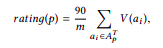


6- Acha que o Top 5 da lista é bem representativo? Compare esse ranqueamento do VAEP com o do xT da Atividade 4. Qual você acha que é mais representativo?

player_id                          player_name  minutes_played  vaep_total  vaep_p90\
       3359       Lionel Andrés Messi Cuccittini          3108.0   35.891377  1.039326\
       8278                    Gareth Frank Bale          1850.0   14.323647  0.696826\
       3802            Philippe Coutinho Correia          1329.0   10.036555  0.679676\
       3322  Cristiano Ronaldo dos Santos Aveiro          2355.0   17.279105  0.660348\
       3682                    Antoine Griezmann          2591.0   18.149570  0.630437\

O ranqueamento do VAEP por 90 minutos leva em conta a quantidade de minutos que eles jogaram. Considerando assim a representatividade, o ranqueamento do VAEP é mais significativo, pois fornece uma perspectiva mais equilibrada em relação ao desempenho dos jogadores, considerando tanto a quantidade de minutos jogados quanto a eficácia de suas ações.
Além disso, os jogadores retornador por esse top 5 são bem mais relevantes que aqueles da Atividade 4, o que indica a melhor qualidade desse modelo.